In [6]:
bsc = xr.open_dataset("nc_files/BSC-DREAM8b v2.0/20211201_BSC_DREAM8b_V2.nc")
bsc

<xarray.Dataset>
Dimensions:     (longitude: 500, latitude: 250, level: 24, time: 25)
Coordinates:
  * longitude   (longitude) float32 -63.0 -62.67 -62.33 ... 102.7 103.0 103.3
  * latitude    (latitude) float32 -11.0 -10.67 -10.33 ... 71.33 71.67 72.0
  * level       (level) float32 86.0 275.0 495.0 ... 1.356e+04 1.502e+04
  * time        (time) datetime64[ns] 2021-12-01T12:00:00 ... 2021-12-04T12:0...
Data variables:
    OD550_DUST  (time, latitude, longitude) float32 ...
    SCONC_DUST  (time, latitude, longitude) float32 ...
    LOAD_DUST   (time, latitude, longitude) float32 ...
    EMI_DUST    (time, latitude, longitude) float32 ...
    PM10_DUST   (time, latitude, longitude) float32 ...
Attributes:
    Model:    BSC-DREAM8b.v2 with calibration factor in the output of 2

In [7]:
# 7 15 23
bsc.time.to_series()[15]

Timestamp('2021-12-03 09:00:00')

In [8]:
nc_files = os.listdir("nc_files/BSC-DREAM8b v2.0/")
len(nc_files)
# nc_files

39

In [9]:
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("nc_files/BSC-DREAM8b v2.0/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.OD550_DUST.time.to_series()[15]]]
    for i in range(len(stn)):
        day1_bsc = bsc.OD550_DUST.isel(time = 15).sel(latitude = stn_lat[i], 
                                                     longitude = stn_lon[i], 
                                                     method = 'nearest')
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        left_on=["stn", "lon", "lat"], 
                                        right_on=["stn", "lon", "lat"],
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

,stn,lon,lat,2021-12-03 09:00:00,2021-12-04 09:00:00,2021-12-05 09:00:00,2021-12-06 09:00:00,2021-12-09 09:00:00,2021-12-10 09:00:00,2021-12-11 09:00:00,...,2022-01-14 09:00:00,2022-01-15 09:00:00,2022-01-18 09:00:00,2022-01-24 09:00:00,2022-01-25 09:00:00,2022-01-27 09:00:00,2022-01-28 09:00:00,2022-01-31 09:00:00,2022-02-01 09:00:00,2022-02-02 09:00:00
0,ABE,3.33,7.20,0.147457,0.162443,0.205442,0.224009,0.187027,0.178645,0.318659,...,0.013021,0.021784,0.069752,0.212193,0.162009,0.222379,0.312071,0.223242,0.212034,0.207176
1,ABK,8.19,6.25,0.179353,0.256591,0.264316,0.206745,0.245862,0.311153,0.284321,...,0.049900,0.040826,0.220951,0.220222,0.231652,0.288454,0.444686,0.282426,0.292670,0.284051
2,ABU,7.20,9.00,0.234977,0.250907,0.257975,0.215780,0.143798,0.153422,0.283354,...,0.053434,0.043941,0.243337,0.174235,0.155345,0.181299,0.268401,0.153099,0.192230,0.243702
3,ADO,5.20,7.60,0.203287,0.212796,0.247987,0.266152,0.223765,0.215836,0.343120,...,0.028899,0.040011,0.109558,0.199903,0.158496,0.224787,0.353874,0.210758,0.218599,0.218693
4,AKU,5.30,7.20,0.190089,0.198412,0.241194,0.265586,0.228629,0.218856,0.332412,...,0.027545,0.041502,0.088338,0.216941,0.173154,0.229669,0.352306,0.219983,0.228184,0.219546
5,ASA,6.23,6.82,0.162129,0.179450,0.236584,0.245625,0.220530,0.258384,0.328667,...,0.026473,0.049463,0.045782,0.223598,0.212685,0.273382,0.383794,0.243395,0.267827,0.235130
6,AWK,7.07,6.20,0.153117,0.197341,0.248829,0.230526,0.219804,0.296955,0.333017,...,0.028975,0.044644,0.041838,0.211246,0.218924,0.290879,0.444900,0.259591,0.285783,0.247597
7,BAU,9.82,10.28,0.223662,0.240186,0.220254,0.174255,0.273463,0.301402,0.259896,...,0.061955,0.045226,0.324077,0.166033,0.179989,0.433789,0.504193,0.228025,0.409553,0.331622
8,BEN,5.60,6.33,0.156818,0.163143,0.211337,0.240683,0.212007,0.227684,0.280520,...,0.024450,0.042812,0.046842,0.239990,0.220447,0.257507,0.336720,0.239887,0.270046,0.232478
9,BID,6.00,9.80,0.216510,0.252213,0.302192,0.250845,0.182044,0.196454,0.313211,...,0.043776,0.033592,0.243270,0.182378,0.151411,0.259192,0.409577,0.199225,0.245143,0.326375


In [10]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()
day1_lead_all_t

stn,index,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
0,2021-12-03 09:00:00,0.147457,0.179353,0.234977,0.203287,0.190089,0.162129,0.153117,0.223662,0.156818,...,0.311414,0.177769,0.149597,0.149468,0.143425,0.141835,0.16772,0.117462,0.252206,0.165433
1,2021-12-04 09:00:00,0.162443,0.256591,0.250907,0.212796,0.198412,0.17945,0.197341,0.240186,0.163143,...,0.281789,0.17328,0.151877,0.21221,0.225675,0.16533,0.17708,0.197418,0.190956,0.173554
2,2021-12-05 09:00:00,0.205442,0.264316,0.257975,0.247987,0.241194,0.236584,0.248829,0.220254,0.211337,...,0.220416,0.230376,0.175096,0.240575,0.20973,0.213629,0.237054,0.221802,0.172871,0.192295
3,2021-12-06 09:00:00,0.224009,0.206745,0.21578,0.266152,0.265586,0.245625,0.230526,0.174255,0.240683,...,0.248275,0.236291,0.103219,0.218334,0.18736,0.235388,0.170667,0.226355,0.161477,0.164779
4,2021-12-09 09:00:00,0.187027,0.245862,0.143798,0.223765,0.228629,0.22053,0.219804,0.273463,0.212007,...,0.434964,0.18578,0.13138,0.216832,0.193559,0.204194,0.126217,0.198908,0.238056,0.181642
5,2021-12-10 09:00:00,0.178645,0.311153,0.153422,0.215836,0.218856,0.258384,0.296955,0.301402,0.227684,...,0.273875,0.170081,0.237628,0.292629,0.198277,0.212371,0.208622,0.194551,0.262205,0.22006
6,2021-12-11 09:00:00,0.318659,0.284321,0.283354,0.34312,0.332412,0.328667,0.333017,0.259896,0.28052,...,0.230948,0.326001,0.146662,0.295466,0.229696,0.258436,0.292132,0.242173,0.156277,0.223699
7,2021-12-12 09:00:00,0.276218,0.211435,0.1321,0.244861,0.254929,0.240985,0.231769,0.134646,0.243311,...,0.148962,0.256115,0.08536,0.218746,0.17544,0.222687,0.138245,0.218081,0.115674,0.099408
8,2021-12-13 09:00:00,0.205157,0.162436,0.103526,0.172446,0.18234,0.168945,0.173097,0.10991,0.176842,...,0.135418,0.166687,0.059955,0.174735,0.141984,0.17385,0.088432,0.172804,0.125929,0.082679
9,2021-12-14 09:00:00,0.164784,0.184539,0.119272,0.16092,0.169323,0.183517,0.192357,0.117083,0.188242,...,0.143934,0.140818,0.072596,0.193806,0.161247,0.191583,0.101067,0.185047,0.132726,0.092556


In [11]:
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
index,,,,,,,,,,,,,,,,,,,,,
2021-12-03,0.147457,0.179353,0.234977,0.203287,0.190089,0.162129,0.153117,0.223662,0.156818,0.21651,...,0.311414,0.177769,0.149597,0.149468,0.143425,0.141835,0.16772,0.117462,0.252206,0.165433
2021-12-04,0.162443,0.256591,0.250907,0.212796,0.198412,0.17945,0.197341,0.240186,0.163143,0.252213,...,0.281789,0.17328,0.151877,0.21221,0.225675,0.16533,0.17708,0.197418,0.190956,0.173554
2021-12-05,0.205442,0.264316,0.257975,0.247987,0.241194,0.236584,0.248829,0.220254,0.211337,0.302192,...,0.220416,0.230376,0.175096,0.240575,0.20973,0.213629,0.237054,0.221802,0.172871,0.192295
2021-12-06,0.224009,0.206745,0.21578,0.266152,0.265586,0.245625,0.230526,0.174255,0.240683,0.250845,...,0.248275,0.236291,0.103219,0.218334,0.18736,0.235388,0.170667,0.226355,0.161477,0.164779
2021-12-09,0.187027,0.245862,0.143798,0.223765,0.228629,0.22053,0.219804,0.273463,0.212007,0.182044,...,0.434964,0.18578,0.13138,0.216832,0.193559,0.204194,0.126217,0.198908,0.238056,0.181642
2021-12-10,0.178645,0.311153,0.153422,0.215836,0.218856,0.258384,0.296955,0.301402,0.227684,0.196454,...,0.273875,0.170081,0.237628,0.292629,0.198277,0.212371,0.208622,0.194551,0.262205,0.22006
2021-12-11,0.318659,0.284321,0.283354,0.34312,0.332412,0.328667,0.333017,0.259896,0.28052,0.313211,...,0.230948,0.326001,0.146662,0.295466,0.229696,0.258436,0.292132,0.242173,0.156277,0.223699
2021-12-12,0.276218,0.211435,0.1321,0.244861,0.254929,0.240985,0.231769,0.134646,0.243311,0.194586,...,0.148962,0.256115,0.08536,0.218746,0.17544,0.222687,0.138245,0.218081,0.115674,0.099408
2021-12-13,0.205157,0.162436,0.103526,0.172446,0.18234,0.168945,0.173097,0.10991,0.176842,0.155506,...,0.135418,0.166687,0.059955,0.174735,0.141984,0.17385,0.088432,0.172804,0.125929,0.082679


In [12]:
# np.array(vis['YOL'])
# merged = pd.merge(vis[["YOL"]], day1_lead_all_t[["YOL"]], left_index=True, right_on="index")
merged = pd.concat([vis[["YOL"]], day1_lead_all_t[["YOL"]]], axis=1)
merged.columns = ["Visibility", "AOD"]
merged

,Visibility,AOD
2021-12-01,10.0,NaN
2021-12-02,1.0,NaN
2021-12-03,1.6,0.252206
2021-12-04,2.0,0.190956
2021-12-05,5.0,0.172871
...,...,...
2022-01-29,5.0,NaN
2022-01-30,5.0,NaN
2022-01-31,8.0,0.240499
2022-02-01,NaN,0.2993


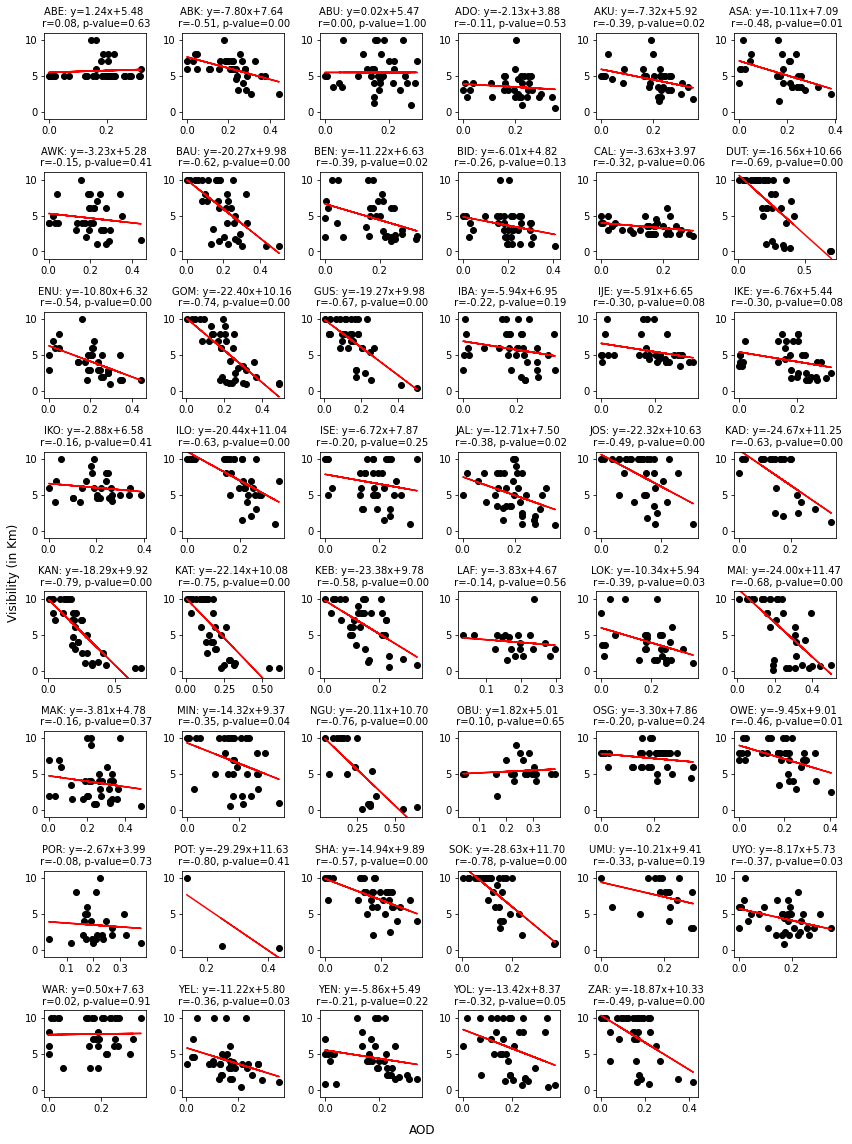

In [13]:
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

cor_ls = []

fig = plt.figure(figsize=(12,16))
# fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    a=merged.dropna()
#     regression part
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(a['AOD']),list(a['Visibility']))
    line = (slope*a['AOD'])+intercept
    
    # append correlation
    cor_ls.append([stn_lat[i], stn_lon[i], j, round(r_value, 2), round(p_value, 2)])
    
    ax = fig.add_subplot(8,6,i+1, )
    ax.scatter(merged['AOD'], merged['Visibility'], color = 'k')
    ax.plot(list(a['AOD']), line, 'r')
    title = j+': y={:.2f}x+{:.2f} \n '.format(slope,intercept)  + 'r={:.2f}, '.format(r_value) + 'p-value={:.2f}'.format(p_value)

    ax.set_title(title, fontsize = 10)
#     ax.set_xlim([0, 1.5])
    ax.set_ylim([-1, 11])
    
#     ax.set_ylabel('Visibility (in Km)')
#     ax.set_xlabel('bbb')
# fig.suptitle('a')
fig.supxlabel('AOD')
fig.supylabel('Visibility (in Km)')
fig.tight_layout(rect=(0.0,0,1,1))
    
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")    
#     plt.subplot(7,7,i+1)
#     plt.scatter(merged['AOD'], merged['Visibility'], color = 'k', ls='solid')
#     plt.title(j)
# plt.xlabel('AOD')
# plt.ylabel('Visibility (in Km)')
#     plt.text(j)
#     for j in stn:
        
#         plt.subplot(2, 3, i)
#         plt.scatter(merged['AOD'], merged['Visibility'])
# # #         plt.text(0.5, 0.5, str((2, 3, i)),
# # #                  fontsize=18, ha='center')
            


# # fig = plt.figure(figsize=(3,3))
# fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(15,15))
# plt.subplots_adjust(hspace=0.2)
# for j, ax in zip(stn, axs.ravel()):
#     print(j, ax)
#     merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
#     merged.columns = ["Visibility", "AOD"]
# #     merged['AOD'].scatter(merged['Visibility'],ax=ax)
#     plt.scatter(merged['AOD'], merged['Visibility'],ax=ax)
# #     plt.figure()
# #     plt.scatter(merged['AOD'], merged['Visibility'],color='k', ls='solid')
# #     plt.show()
    
    

In [14]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
# cor_df

In [15]:
# cor_df.to_csv("cor_files/day1/bsc_dream_1d.csv", index=False)
cor_df.to_csv("cor_files/day2/bsc_dream_2d.csv", index=False)
# cor_df.to_csv("cor_files/day3/bsc_dream_3d.csv", index=False)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ticks'

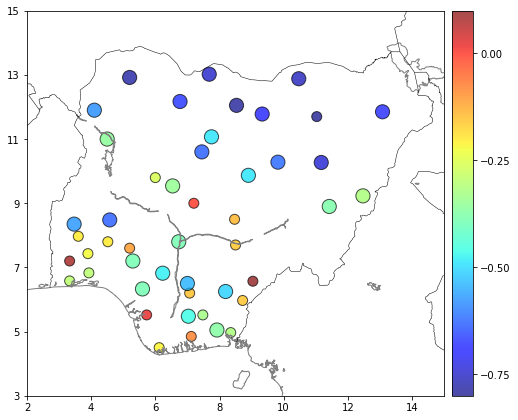

In [17]:
# plot coastlines with Basemap
plt.figure(figsize=(8, 8))
m=Basemap(projection='cyl', resolution='h',
llcrnrlat=3, urcrnrlat=15,
llcrnrlon=2, urcrnrlon=15)
# m.drawmapboundary(fill_color='#DDEEFF')
# m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='grey', zorder=2)
m.drawcountries(color='black', zorder=2)
# m.shadedrelief()
m.drawstates()

# m.readshapefile('./nigeria_states/nigeria_states', 'nigeria_states')

# plot locations
m.scatter(cor_df["Long"], cor_df["Lat"], latlon=True, 
          c=cor_df["r_value"], s=cor_df["p"]*100,
          edgecolors="black", 
          cmap='jet', alpha=0.7)
m.colorbar(ticks=np.linspace(1, -1, 9, endpoint=True))

# create colorbar and legend
# m.colorbar(label='r', ticks=np.linspace(1, -1, 9, endpoint=True), shrink=0.755)
# # m.set_ticks(np.linspace(1, -1, 9))
plt.xticks(range(2, 16, 2))
plt.yticks([3, 5, 7, 9, 11, 13, 15])
plt.set_ticks(['3N', '5N', '7N', '9N', '11N', '13N', '15N'])

# plt.show()